In [1]:
# Loading some dependencies
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
# The dataset used is a small corpus of out-of-copyright books from Project Gutenberg. The corpus is available with nltk so
# it can be easily loaded with  this
from nltk.corpus import gutenberg

## Tokenanization

In [3]:
# This small corpus consists of 18 literary works
len(gutenberg.fileids())

18

In [4]:
# These are the books
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [5]:
# Number of combined words in the books
len(gutenberg.words())

2621613

In [6]:
# Example of how to tokenize the entire corpus into a list of sentences
gberg_sent_tokens = sent_tokenize(gutenberg.raw())

In [7]:
# The first item of the list containing: title, chapter markers, the first sentence
# NOTE: The /n aren't supposed to be there but eh what can you do
gberg_sent_tokens[0]

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.'

In [8]:
# The first stend-alone sentence
gberg_sent_tokens[1]

"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period."

In [9]:
# The first sentence tokenized to the word level
word_tokenize(gberg_sent_tokens[1])

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'s",
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

In [10]:
# Just to prove that the method word_tokenize returns a list
word_tokenize(gberg_sent_tokens[1])[14]

'father'

In [11]:
# Although sent_tokenize() and word_tokenize() may come in handy when dealing with other data, the Project Gutenberg corpus
# has its own tokenization methods
gberg_sents = gutenberg.sents()
# This specific method produces a list of lists

In [12]:
gberg_sents[0:3]

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'],
 ['VOLUME', 'I'],
 ['CHAPTER', 'I']]

In [13]:
# To access the same word from a couple cells above: 'father'
gberg_sents[4][14]

'father'

## Converting all characters to lowercase

In [14]:
# The reason we might want to convert words to lowercase is so that 'She' and 'she' are treated as the same word and thus be
# placed on a more accurate location in the vector-space because the word has more instances
[w.lower() for w in gberg_sents[4]]

['she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

## Removing stop words and punctuation

In [15]:
# Punctuations marks generally don't add much value to a natural language model and so are often removed

# There are frequently occuring words that tend to contain relatively little distinctive meaning, such as 'the', 'at', 
# 'which', and 'of'. There is no universal concensus on the precise list of stop words, but depending on your application it
# may be sensible to ensure that certain words are or aren't considered to be stop words. Some lists of stopwords include 
# negations like 'didn't' or 'insn't' and 'wouldn't' that might be critical is you are trying to classify sentiment for 
# example. Be careful.

# The 'stopwords.words' is for actual english words and the 'string.punctuation' is only for punctuation
stpwords = stopwords.words('english') + list(string.punctuation)

In [16]:
stpwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
# Removing the stopwords and punctuation from the sentence we've been using
[w.lower() for w in gberg_sents[4] if w.lower() not in stpwords]

['youngest',
 'two',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period']

## Stemming

In [18]:
# Remember that to stem words means to take the stem of a word, like 'hous' being the stem of 'house' and 'housing'
# To stem words, the Porter algorithm is used, which is provided by nltk. To do this, create an instance of a 
# PorterStemmer() object and then add its stem() method to the list comprehension
stemmer = PorterStemmer()

In [19]:
# Notice how the words have been stemmed
[stemmer.stem(w.lower()) for w in gberg_sents[4] if w.lower() not in stpwords]

['youngest',
 'two',
 'daughter',
 'affection',
 'indulg',
 'father',
 'consequ',
 'sister',
 'marriag',
 'mistress',
 'hous',
 'earli',
 'period']

## Handling n-grams

In [20]:
# Some words commonly co-occur in such a way that the combination of words is better suited to being considered a single
# concept than several separate concepts, such as grouping 'New York City' together instead of considering 'New' 'York' and
# 'City' as different elements

# We can use the Phrases() and Phraser() methods from the gensim library to handle n-grams

In [21]:
# The Phrases() method can be used to train "detector" to identify how often any given pair of words occurs together in our
# corpus (the technical term for this is "bigram collocation") relative to how often each word in the pair occurs by itself

phrases = Phrases(gberg_sents)

In [22]:
# The Phraser() method can be used to take the bigram collocations detected by the Phrases object and then use this
# information to create an object that can efficiently be passed over our corpus, converting all bigram locations into a
# single token

bigram = Phraser(phrases)

In [23]:
# By running phrasegrams, we output a dictionary of the count and score of each bigram. As an example let's go over the 
# first pair. The key in the dictionary includes a tuple with the word pairing. The value of the dictonary includes a score 
# which measures how often the two terms occur together relative to how often they occur apart

# NOTE: Notice how there is still punctuation and capitalization inside. This will be addressed later.

# NOTE: This method no longer displays the amount of instances each pair occurred as it did before
bigram.phrasegrams

{(b'two', b'daughters'): 11.966813731181546,
 (b'her', b'sister'): 17.7960829227865,
 (b"'", b's'): 31.066242737744524,
 (b'very', b'early'): 11.01214147275924,
 (b'Her', b'mother'): 13.529425062715127,
 (b'long', b'ago'): 63.22343628984788,
 (b'more', b'than'): 29.023584433996874,
 (b'had', b'been'): 22.306024648925288,
 (b'an', b'excellent'): 39.063874851750626,
 (b'Miss', b'Taylor'): 453.75918026073305,
 (b'very', b'fond'): 24.134280468850747,
 (b'passed', b'away'): 12.35053642325912,
 (b'too', b'much'): 31.376002029426687,
 (b'did', b'not'): 11.728416217142811,
 (b'any', b'means'): 14.096964108090186,
 (b'wedding', b'-'): 17.4695197740113,
 (b'Her', b'father'): 13.129571562488772,
 (b'after', b'dinner'): 21.5285481168817,
 (b'self', b'-'): 47.79018053120332,
 (b'sixteen', b'years'): 107.0461671612265,
 (b'five', b'years'): 40.128755673408115,
 (b'years', b'old'): 54.735425236061104,
 (b'seven', b'years'): 52.59411150244507,
 (b'each', b'other'): 79.4168405322873,
 (b'a', b'mile'): 

In [30]:
# Notice how we can now use the bigram object we created
tokenized_sentence = 'Jon lives in New York City'.split()

In [31]:
tokenized_sentence

['Jon', 'lives', 'in', 'New', 'York', 'City']

In [32]:
# The sentence has now been tokenized with 'New York' as a single token
bigram[tokenized_sentence]

['Jon', 'lives', 'in', 'New_York', 'City']

In [33]:
# The name "bigrams" comes from 2. If we wish to detect trigrams in this corpus we can pass this new bigram-filled corpus 
# through the Phrases() and Phraser() methods again. This could be repeated to find 4-grams and 5-grams however there are 
# diminishing returns for this. Bigrams, or at most trigrams, should suffice for the majority of applications.

## Preprocessing the full corpus

In [34]:
# We will not stem words or remove stop words

In [36]:
# Creating a new corpus with all lowercase and no puncuation
lower_sents = []
for s in gberg_sents:
    lower_sents.append([w.lower() for w in s if w.lower() not in list(string.punctuation)])

In [37]:
# Detecting collocated bigrams across the new corpus
lower_bigram = Phraser(Phrases(lower_sents))

In [38]:
# Comparing this bigram dictionary with the last one we can see that this one has no capitalized words or punctuation
lower_bigram.phrasegrams

{(b'two', b'daughters'): 11.080802900992637,
 (b'her', b'sister'): 16.93971298099339,
 (b'very', b'early'): 10.516998773665177,
 (b'her', b'mother'): 10.70812618607742,
 (b'long', b'ago'): 59.226442015336005,
 (b'more', b'than'): 28.529926612065935,
 (b'had', b'been'): 21.583193129694834,
 (b'an', b'excellent'): 37.41859680854167,
 (b'sixteen', b'years'): 131.42913000977515,
 (b'miss', b'taylor'): 420.4340982546865,
 (b'mr', b'woodhouse'): 104.19907841850323,
 (b'very', b'fond'): 24.185726346489627,
 (b'passed', b'away'): 11.751473221742694,
 (b'too', b'much'): 30.36309017383541,
 (b'did', b'not'): 10.846196223896685,
 (b'any', b'means'): 14.294148100212627,
 (b'after', b'dinner'): 18.60737125272944,
 (b'mr', b'weston'): 91.63290824201266,
 (b'five', b'years'): 37.66428596665674,
 (b'years', b'old'): 48.599094446190286,
 (b'seven', b'years'): 50.3345604292756,
 (b'each', b'other'): 71.31277029783762,
 (b'well', b'informed'): 14.185028016786625,
 (b'a', b'mile'): 11.700110753652233,
 (b

In [39]:
# Examining the results, however, it appears that the default minimum thresholds for determining what is a bigram are far 
# too liberal. Word pairs like "two daughters" and "her sister" should not be considered bigrams. To attain better bigrams 
# we experimented with more conservative thresholds by increasing them by powers of two. Although the result is not perfect 
# because there are still bigrams like "great deal" and "few minutes", the output is still much better
lower_bigram = Phraser(Phrases(lower_sents, min_count=32, threshold=64))

In [61]:
lower_bigram.phrasegrams

{(b'miss', b'taylor'): 156.44059469941823,
 (b'mr', b'woodhouse'): 82.04651843976633,
 (b'mr', b'weston'): 75.87438262077481,
 (b'mrs', b'weston'): 160.68485093258923,
 (b'great', b'deal'): 93.36368125424357,
 (b'mr', b'knightley'): 161.74131790625913,
 (b'miss', b'woodhouse'): 229.03802722366902,
 (b'years', b'ago'): 74.31594785893046,
 (b'mr', b'elton'): 121.3990121932397,
 (b'dare', b'say'): 89.94000515807346,
 (b'frank', b'churchill'): 1316.4456593286038,
 (b'miss', b'bates'): 276.39588291692513,
 (b'drawing', b'room'): 84.91494947493561,
 (b'mrs', b'goddard'): 143.57843432545658,
 (b'miss', b'smith'): 73.03442128232508,
 (b'few', b'minutes'): 204.16834974753786,
 (b'john', b'knightley'): 83.03755747111268,
 (b'don', b't'): 250.30957446808512,
 (b'good', b'natured'): 88.69936184891343,
 (b'few', b'moments'): 107.77584531675087,
 (b'thousand', b'pounds'): 166.51834523092802,
 (b'o', b'clock'): 89.14789088153573,
 (b'jane', b'fairfax'): 654.5565917587609,
 (b'miss', b'fairfax'): 196.

In [42]:
# Now that we have a decent lower_bigram object we can at last use a for loop to iteratively append for ourselves a corpus 
# of cleaned-up sentences
clean_sents = []
for s in lower_sents:
    clean_sents.append(lower_bigram[s])

In [43]:
# Notice how all is lowercase, there is no punctuation, and we have various bigrams
clean_sents[6]

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

## Creating word embeddings with word2vec

In [44]:
# Word2vec can be run in a single line- albeit with quite a few arguments
model = Word2Vec(sentences=clean_sents, size=64, sg=1, window=10, iter=5, min_count=10, workers=4)

#Breakdown of each of the parameters:

# sentences: Pass in a list of lists like clean_sents as a corpus. Elements in the higher-level list are sentences, whereas
# elements in the lower-level list can be word-level tokens

# size: The number of dimensions in the word-vecotr space that will result from running word2vec. This is a hyperparameter 
# that can be varied and evaluated extrinsically or intrinsically. Like other hyperparameters in this book, there is a 
# Goldilocks sweetspot. You can home in on an optimal value by specifying, say, 32 dimensions and varying this value by 
# powers of 2. Remember the rule of using the least number of dimensions possible without increasing cost.

# sg: Set to 1 to choose the skip-gram architecture, or leave at the 0 default to choose CBOW (Continuous Bag Of Words). SG 
# is generally better suited to smaller datasets like our Gutenberg corpus.

# window: The number of context words to each side of the target word considered in our model. For SG, a window size of 10  
# (for a total of 20 context words) is a good bet. If we were using a CBOW, then a window size of 5 (for a total of 10 
# context words) could be near the optimal value. In any case this hyperparameter can be experimented with and evaluated 
# extrinsically or intrinsically. Small adjustments to this hyperparameter may not be perceptfully impactful, however.

# iter: By default, the gensim Word2vec() methodd iterates over the corpus fed into it five times. Multiple iterations of 
# word2vec is analogous to multiple epochs of training a deep learning model. With a small corpus like ours, the word 
# vectors improve over several iterations. With a very large corpus it might be cripplingly computationally expensive to 
# run even two iterations- and because there are so many examples of words in a very large corpus anyway, the word vectors 
# might not get any better

# min_count: The minimum number of times a word must occur across the corpus in order to fit it into word-vector space. If 
# a given target word occurs only a few times, there are a limited number of examples of its contextual words to consider, 
# and so its location in word-vecotr space may not be reliable. A minimum count of 10 is often reasonable. The higher the 
# count, the smaller the vocabulary of words that will be available to your downstream NLP task. This is yet another 
# hyperparameter that cana be tuned, with extrinsic evaluations likely being more illuminating than intrinsic ones because 
# the size of the vocabulary you have to work with could make a considerable impact on your downstream NLP application.

# workers: The number of processingcores you'd like to dedicate to training. If the CPU on your machine has, say, eight 
# cores, then eight is the largest number of parallel workers threads you can have. In this case, if you choose to use fewer
# than eight cores, you're leaving computing resources for other tasks. The laptop used at the time of writing has 4 cores.

In [45]:
# The size of our vocabulary. Remember that this is the number of words that had 10 instances or more. There would be about 
# 17k words if we carried out no preprocessing.
len(model.wv.vocab)

10329

In [46]:
# We can output the location of any word, such as "dog", from our corpus in 64-dimensional word-vector space by using:
model.wv['dog']

array([ 0.17416792, -0.20561661,  0.16318585, -0.3082229 ,  0.02963606,
        0.22172537,  0.22292918,  0.10392997,  0.24178456,  0.27541083,
       -0.35978   , -0.58413064, -0.056913  ,  0.3382601 ,  0.22975942,
        0.2971917 ,  0.12901162, -0.2796988 ,  0.05138711,  0.16105863,
        0.3418006 , -0.24917832,  0.0411971 ,  0.21883543, -0.00330519,
        0.06934781,  0.07120437, -0.19591025,  0.2801062 ,  0.34483376,
        0.12528594, -0.19481485,  0.32596698,  0.09039564,  0.06103064,
        0.733922  , -0.28881055, -0.15872227,  0.26330099, -0.39086404,
        0.2471046 , -0.15432087,  0.1490626 ,  0.02528954,  0.23878762,
       -0.4139153 , -0.04613177, -0.04083127,  0.33078182,  0.8159266 ,
        0.75381416,  0.04353354,  0.44299442,  0.11554883,  0.08505054,
        0.225861  ,  0.11632169,  0.1254611 , -0.03261553,  0.3365388 ,
        0.39258417,  0.42566764,  0.28035063, -0.19100057], dtype=float32)

In [47]:
# The number of dimensions in our word-vector space
len(model.wv['dog'])

64

In [51]:
# As a rudimentary intrinsic evaluation of the quality of our word vectors, we can use the most_similar() method to confirm 
# that words with similar meanings are found in similar locations within our word-vector space. The similarity between two 
# given words is computed here by calculating the cosine similarity.

# The first argument is the word you wish and the second is the number of similar words you want 
model.wv.most_similar('dog',topn=3)

[('puppy', 0.7786027193069458),
 ('pet', 0.7565591335296631),
 ('cage', 0.7459152936935425)]

In [52]:
# By most similar, it means the two words have the shortest Euclidian distence in the 64-dimensional vector space
model.wv.most_similar('father',topn=3)

[('mother', 0.8140692114830017),
 ('brother', 0.744711697101593),
 ('sister', 0.7136675715446472)]

In [53]:
model.wv.most_similar('day',topn=3)

[('morning', 0.7828391790390015),
 ('week', 0.735389232635498),
 ('night', 0.7223672866821289)]

In [54]:
model.wv.most_similar('eat',topn=3)

[('bread', 0.84517502784729),
 ('drink', 0.8247072100639343),
 ('meat', 0.7511327266693115)]

In [55]:
model.wv.most_similar('ma_am',topn=3)

[("'--", 0.854072093963623),
 ('betty', 0.8442432880401611),
 ('m_sure', 0.8414121866226196)]

In [56]:
# Dog is the word that is the least similar relative to all the other possible word pairs
model.wv.doesnt_match('mother father sister brother dog'.split())

C:\Users\alex\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'dog'

In [57]:
# We can also use the similarity method to flat out see the similarity between words.
model.wv.similarity('father','dog')

0.49834788

In [58]:
model.wv.similarity('son','dog')

0.35702422

In [59]:
# As a final little intrinsic test, we can compute word-vector analogies. For example, to calculate "father - man + woman "
# we can execute this code:

# NOTE: Top score should be mother, but due to any number of reasons the model did not perform to expectations. We can 
# see, however, that mother is not far from the top.
model.wv.most_similar(positive=['father','woman'], negative=['man'])

[('husband', 0.7760298252105713),
 ('sister', 0.7744160294532776),
 ('wife', 0.766646683216095),
 ('mother', 0.7614957094192505),
 ('daughter', 0.7592054605484009),
 ('tamar', 0.71018385887146),
 ('conceived', 0.704203724861145),
 ('rebekah', 0.6902408599853516),
 ('brother', 0.6811164617538452),
 ('loved', 0.6787464618682861)]

In [60]:
# In this case our model did perform excellently
model.wv.most_similar(positive=['husband','woman'], negative=['man'])

[('wife', 0.7260440587997437),
 ('sister', 0.7006030082702637),
 ('maid', 0.6894023418426514),
 ('daughter', 0.6749671697616577),
 ('conceived', 0.6469721794128418),
 ('child', 0.6462420225143433),
 ('mother', 0.6437892913818359),
 ('elder', 0.6301178932189941),
 ('nurse', 0.6191160678863525),
 ('maiden', 0.6119976043701172)]

## Plotting word vectors

In [63]:
# Humans are not well-suited to visualize things in more than 3 dimensions, so the following steps can be taken to reduce 
# the number of dimensions of the word-vector space

# NOTE: t-SNE is stochastic, so unique results will be achieved each time it is run. 

tsne = TSNE(n_components=2, n_iter=1000)

# The "n_components" argument is the number of dimensions that will be returned.

# The n_iter is the number of iterations over the input data. As with word2vec, iterations are analogous to the epochs 
# associated with training a neural network. More iterations corresponds to a longer training time but may improve results.

X_2d = tsne.fit_transform(model.wv[model.wv.vocab])
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = model.wv.vocab.keys()

In [64]:
# Head of the dataframe we just created. Each unique token has a unique x and y coordinate
coords_df.head()

,x,y,token
0,63.884998,2.589447,emma
1,17.806892,-45.457920,by
2,64.524551,-0.321421,jane
3,18.502579,-13.194394,volume
4,20.982510,35.761326,i


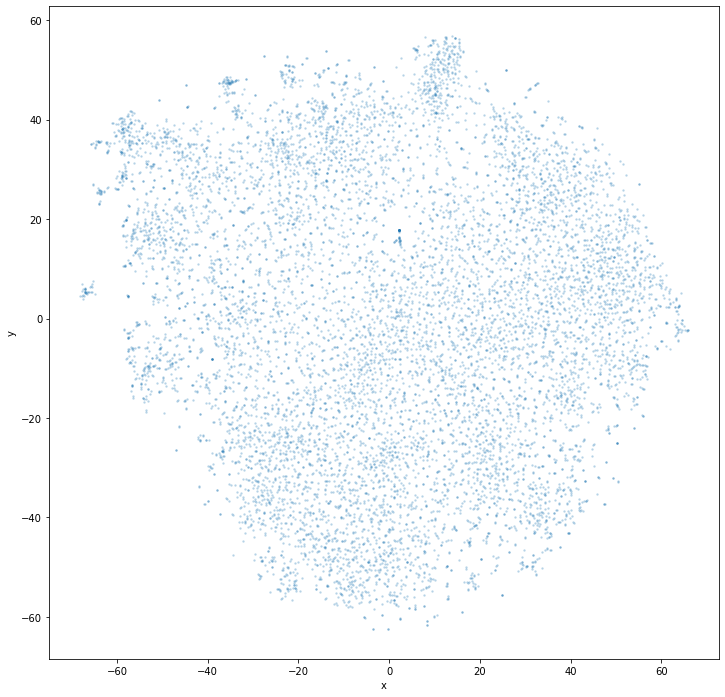

In [65]:
# Creating a scatterplot  of the word-vector space
_ = coords_df.plot.scatter('x','y',figsize=(12,12), marker='.', s=10, alpha=0.2)

In [67]:
# The previous scatterplot may look interesting, but there's little actionable information we can take away from it. 
# Instead, we can use the "bokeh" library to create a highly interactive and actionable plot.
output_notebook()
subset_df = coords_df.sample(n=5000)
p = figure(plot_width=800, plot_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

# NOTE: We are only using 5000 words from our word-space dataframe. We can change this by messing around with the "n" 
# argument or just flat-out use the original dataframe.

# By using the controls on the right you can zoom-in and move around to find little clusters of words with similar meanings 
# and/or contexts. Doing this little intrinsic evaluation may also lead you to find shortcomings of your model such as 
# punctuation marks, or other tokens that you wish weren't included in your word-space vector.

Loading BokehJS ...

In [ ]:
v